# Analysis of excitonic states

In [1]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


We read the coupling matrix and dipoles (with the highest given number of virtual orbitals)

In [2]:
nVirtMax = 303
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_'+str(nVirtMax)+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_'+str(nVirtMax)+'.txt'
Cmat = np.loadtxt(cpath)
%cd ..
Cmat.shape

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


(3030, 3030)

We set the number of empty and virtual states and build the C submatrix with the chosen values of nalpha

In [3]:
numOrb = 5
nalpha = [32,64,128,nVirtMax]

We compute the eigenvalues and vectors of C_ext (linalg.eigh gives the eigenvectors in the transpose form so we peform an explicit transpose to the vectors sorted as row vectors)

In [4]:
eigenproblems = {}
for na in nalpha:
    C_ext,dipoles_ext=R.extract_subset([numOrb],[nVirtMax],Cmat,dipoles,[na])
    print C_ext.shape
    E2,C_E2 = np.linalg.eigh(C_ext)
    C_E2 = C_E2.T
    eigenproblems[na] = (C_ext,E2,C_E2)

(320, 320)
(640, 640)
(1280, 1280)
(3030, 3030)


In [5]:
for na in nalpha:
    C_ext = eigenproblems[na][0]
    E2 = eigenproblems[na][1]
    C_E2 = eigenproblems[na][2]
    for ind,e in enumerate(E2):
        isok = np.allclose(C_ext.dot(C_E2[ind]),e*C_E2[ind],atol=1.e-12)
        if not isok: print('Eigenvalue',ind,'is false')
print('Validation terminated')

Validation terminated


We choose a set of excitations and compute the contribution of the virtual states in the corresponding eigenstates of C_ext

In [10]:
exc = [0,1,7] # [i for i in range(20)] # select the list of excitation index

In [11]:
reload(R)
weightP,weightAlpha = R.weight(numOrb,nalpha,exc,eigenproblems)

nalpha =  32

Excitation number : 1  energy =  7.36721935915
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99974275101
  1 - sumOverThreshold p =  2.572e-04
  ******* virtual state contribution *********
  virtual state  : 2  weight =  0.999495503353
  1 - sumOverThreshold alpha =  5.045e-04

Excitation number : 2  energy =  7.36722034469
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.999744978956
  1 - sumOverThreshold p =  2.550e-04
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.999496672574
  1 - sumOverThreshold alpha =  5.033e-04

Excitation number : 8  energy =  9.35069114923
  ******* occupied state contribution ********
  occupied state : 3  weight =  0.500000838245
  occupied state : 4  weight =  0.499999161755
  1 - sumOverThreshold p =  4.392e-13
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.499999161755
  virtual state  : 2  weight =  0.5

We build a dictionary that collects all the excitations. These quantities contain, for each value of the number of virtual orbitals, the eigenproblems data and the transition data. This latter dictionary is parametreized in term of the
findTransition parameter and contains the weights (p and alpha) and the index of the eigenvalue

In [13]:
excitations = {}
for a,na in enumerate(nalpha):
    transitions = {}
    for i in range(len(exc)):
        tr = R.findTransition(weightP[a][i],weightAlpha[a][i])
        transitions[tr] = {'weightP' : weightP[a][i], 'weightAlpha' : weightAlpha[a][i], 'ind' : i}
    excitations[na] = {'Cmat' : eigenproblems[na][0], 'E2': eigenproblems[na][1], 'C_E2' : eigenproblems[na][2], 'transitions' : transitions}

In [15]:
# example
excitations[32]['transitions']

{'34to12': {'ind': 2,
  'weightAlpha': array([  4.99999162e-01,   5.00000838e-01,   1.75910018e-15,
           2.54013972e-13,   1.09030098e-13,   1.80029790e-17,
           7.20281724e-17,   1.71758830e-17,   1.29497082e-20,
           1.33764322e-15,   7.76762151e-14,   3.05484768e-16,
           3.95047933e-19,   3.16823383e-16,   1.52130776e-15,
           1.40477652e-15,   1.38004504e-17,   2.43141534e-20,
           5.93193640e-17,   9.08705210e-14,   4.12461144e-14,
           6.77020339e-18,   4.85505039e-16,   1.42572574e-17,
           5.18546097e-17,   4.33104606e-16,   3.54622278e-18,
           4.28662881e-18,   5.70966158e-19,   4.82485613e-16,
           4.56404416e-18,   4.11532318e-18]),
  'weightP': array([  1.15693238e-13,   2.44464253e-13,   5.00000838e-01,
           4.99999162e-01,   7.79132740e-14])},
 '5to1': {'ind': 1,
  'weightAlpha': array([  9.99496673e-01,   4.83722246e-10,   6.89184427e-09,
           9.07101951e-05,   3.30195657e-05,   4.29481316e-09,
   

To know which transition are included in the exc list we can compute

In [27]:
transitionVal = []
for na in nalpha:
    for key in excitations[na]['transitions']:
        transitionVal.append(key)
transitionVal = list(set(transitionVal))
transitionVal

['5to2', '34to12', '5to1']

Remove the components above the threshold

In [31]:
def weightCut(w, threshold = 0.1):
    wCut = np.zeros(len(w))
    for i,ww in enumerate(w):
        if ww < threshold:
            wCut[i] = ww
    return wCut

In [32]:
bla = weightCut(weightP[0][0])
bla

array([  7.59493823e-05,   5.74604645e-05,   4.89211047e-06,
         1.18947033e-04,   0.00000000e+00])

selected transition :  5to2


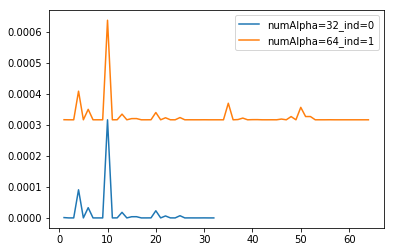

In [52]:
tr = transitionVal[0]
print 'selected transition : ', tr
offset = 0.0
for na in nalpha:
    if tr in excitations[na]['transitions'].keys():
        alpha = [i for i in range(1,na+1)]
        wAlpha = weightCut(excitations[na]['transitions'][tr]['weightAlpha'])
        ind = str(excitations[na]['transitions'][tr]['ind'])
        plt.plot(alpha,offset + wAlpha,label = 'numAlpha='+str(na) + '_ind='+ind)
        offset = max(wAlpha)
plt.legend()        
plt.show()

selected transition :  34to12


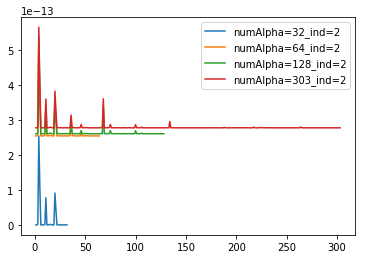

In [55]:
tr = transitionVal[1]
print 'selected transition : ', tr
offset = 0.0
for na in nalpha:
    if tr in excitations[na]['transitions'].keys():
        alpha = [i for i in range(1,na+1)]
        wAlpha = weightCut(excitations[na]['transitions'][tr]['weightAlpha'])
        ind = str(excitations[na]['transitions'][tr]['ind'])
        plt.plot(alpha,offset + wAlpha,label = 'numAlpha='+str(na) + '_ind='+ind)
        offset = max(wAlpha)
plt.legend()        
plt.show()

selected transition :  5to1


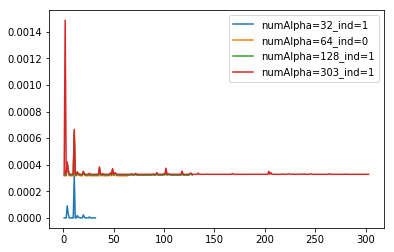

In [56]:
tr = transitionVal[2]
print 'selected transition : ', tr
offset = 0.0
for na in nalpha:
    if tr in excitations[na]['transitions'].keys():
        alpha = [i for i in range(1,na+1)]
        wAlpha = weightCut(excitations[na]['transitions'][tr]['weightAlpha'])
        ind = str(excitations[na]['transitions'][tr]['ind'])
        plt.plot(alpha,offset + wAlpha,label = 'numAlpha='+str(na) + '_ind='+ind)
        offset = max(wAlpha)
plt.legend()        
plt.show()

In [ ]:
####################################################################################################

We analyze the formation of wave packet in the virtual states with a low weight on the eigenvectors of C. We consider a single excitation and plot the contribution of the states below the threshold (for each value of the number of virtual states)

nalpha =  32
Excitation number : 1  energy =  7.36721935915
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99974275101
  1 - sumOverThreshold p =  2.572e-04
  ******* virtual state contribution *********
  virtual state  : 2  weight =  0.999495503353
  1 - sumOverThreshold alpha =  5.045e-04

nalpha =  64
Excitation number : 1  energy =  7.3628480509
  ******* occupied state contribution ********
  occupied state : 5  weight =  0.99965926888
  1 - sumOverThreshold p =  3.407e-04
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.999353603709
  1 - sumOverThreshold alpha =  6.464e-04

nalpha =  128
Excitation number : 1  energy =  7.34587283931
  ******* occupied state contribution ********
  occupied state : 3  weight =  0.498665597369
  occupied state : 4  weight =  0.498663588088
  1 - sumOverThreshold p =  2.671e-03
  ******* virtual state contribution *********
  virtual state  : 1  weight =  0.49579786782
  virtual st

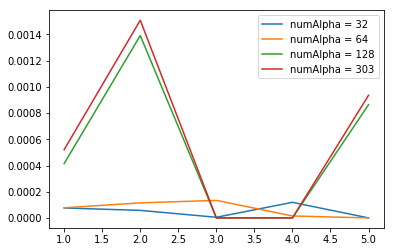

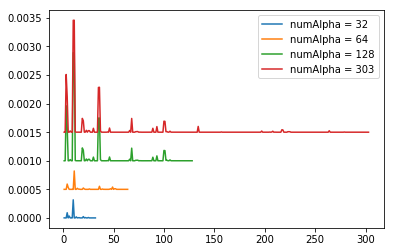

In [7]:
exc = [0] #select the excitation index
weightP = []
weightAlpha = []
for inda in range(len(nalpha)):
    print 'nalpha = ', nalpha[inda]
    wP,wAlpha = R.weight(numOrb,nalpha[inda],exc,eigenproblems[nalpha[inda]][2],eigenproblems[nalpha[inda]][1])
    weightP.append(wP[0])
    weightAlpha.append(wAlpha[0])
    
# remove the component above the treshold
weightAlphaCut = weightAlpha
for a in range(len(nalpha)):
    for i,w in enumerate(weightAlphaCut[a]):
        if w > 0.1:
            weightAlphaCut[a][i] = 0.0
weightPCut = weightP
for a in range(len(nalpha)):
    for i,w in enumerate(weightPCut[a]):
        if w > 0.1:
            weightPCut[a][i] = 0.0
#plot
p = [i for i in range(1,numOrb+1)]
for a in range(len(nalpha)):
    plt.plot(p,weightPCut[a],label = 'numAlpha = ' + str(nalpha[a]))
    plt.legend()
plt.show()

offs = 0
for a in range(len(nalpha)):
    alpha = [i for i in range(1,nalpha[a]+1)]
    plt.plot(alpha,offs + weightAlphaCut[a],label = 'numAlpha = ' + str(nalpha[a]))
    offs+=5e-4 #2e-13 
    plt.legend()
plt.show()